In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

In [701]:
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, option_context, to_datetime, read_csv, read_excel, crosstab
import regex as re
from datetime import datetime, date
import numpy as np

In [3]:
# defining the scope of the application
scope_app = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive'] 

#credentials to the account
cred = ServiceAccountCredentials.from_json_keyfile_name('baby-sleep-war-89c8dcb4a508.json',scope_app) 

# authorize the clientsheet 
client = gspread.authorize(cred)

In [4]:
def print_all(text):
    with option_context('display.max_rows', None, 'display.max_columns', None):  
        # more options can be specified also
        print(text)

In [350]:
spreadsheet_id = '1l-bLCA0f4gsYgnDE6aeoTM9nH5uuc48Z1zRw9uHTNjo'
range_name = 'A1:BA1300'
#sh = client.open('baby-sleep_war')

service = build('sheets', 'v4', credentials=cred)
result = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
answers = result.get('values', [])
print(f"{len(answers)} rows retrieved")

df_zero = DataFrame(answers[1:], columns=answers[0])
#print(df.info())

1236 rows retrieved


In [562]:
df = df_zero.copy()

col_names_en = {
    'Отметка времени': "time",
    'Адрес электронной почты':	"email",
    '1. У якому населеному пункті України ви проживали до 24 лютого 2022 року?':	"location_before",
    '2. Скільки зараз вашій (молодшій) дитині? Дата народження у форматі дд.мм.рррр ':	"birthday_younger",
    '3. Стать (молодшої) дитини':	"gender_younger",
    '4. Якщо у вас більше, ніж одна дитина, вкажіть вік (дати народження) старших дітей. \nЯкщо у вас тільки 1 дитина, поставте "-", будь ласка ':	"birthday_older",
    '5. Стать старшої дитини (дітей). Якщо у вас тільки 1 дитина, поставте "-"  ':	"gender_older",
    '6. Який тип вигодовування у вашої (молодшої) дитини?':	"feeding",
    '7. Чи є особливості стану здоров’я дитини, на які ви звертали увагу до 24 лютого? ':	"health",
    '8. Як ви б оцінили сон вашої дитини до 24 лютого? (від 1 до 5, де 1 – жахливий сон, 5 – чудовий сон)? ':	"kidsleep_grade_before",
    '9. Як, на вашу думку, змінився сон вашої дитини у перший місяць повномасштабної війни від 24 лютого 2022 року? ':	"kidsleep_dynamics",
    '10. Чи працювали ви над сном дитини до 24 лютого 2022 року?':	"sleep_experience",
    '11. Чи залишали ви ваше місце проживання разом з дітьми після 24 лютого? ':	"leave_home",
    "12. Якщо у попередньому питанні ви відповіли так, у який день ви це зробили? Якщо ви точно не пам'ятаєте дату, вкажіть приблизний день ":	"when_leave_home",
    '13. Чому ви прийняли рішення це зробити? (Якщо ви не залишали місце проживання, залиште "-" у відповідь на це питання) ':	"why_leave_home",
    '14. Яким транспортом ви здійснювали переїзд? ':	"transport_lh",
    '15. Скільки годин тривала ваша дорога до нового місця проживання? (цифра, годин) ':	"lh_duration",
    '16. Як був організований сон дитини під час дороги? ':	"kidsleep_lh",
    '17. У яку локацію ви змушені були переїхати? ':	"new_location",
    '18. Чи був у вас досвід перебування з дитиною у бомбосховищі/підвалі? ':	"shelter_experience",
    '19. Чи був у вас досвід сну з дитиною у бомбосховищі/підвалі? ':	"shelter_kidsleep",
    '20. Як було у сховищі організоване місце для сну дитини? ':	"shelter_organisation",
    '21. Чи доводилося вам вкладати спати дитину у верхньому одязі? ':	"outerwear_kidsleep",
    '22. Чи доводилося вам вкладати спати дитину при низькій температурі в приміщенні? ':	"coldroom_kidsleep",
    '23. Чи довелося вам знаходитися у ситуації з обмеженим доступом до питної води? ':	"lack_water",
    '24. Скільки днів ви знаходилися у ситуації обмеженого доступу до води? ':	"lack_water_duration",
    '25. Чи довелося вам знаходитися у ситуації з обмеженим доступом до продуктів харчування? ':	"lack_food",
    '26. Чи був у вас досвід перебування з дитиною без електроенергії? ':	"lack_elecricity",
    '27. Чи довелося вам розлучити дитину з рідними, звичним оточенням? ':	"kid_separation",
    '28. Чи був у вас досвід вкладання дитини у коридорі квартири/будинку «за правилом двох стін»? ':	"2walls",
    '29. Як було організоване спальне місце дитини у коридорі?':	"2walls_sleeporganization",
    '30. Як ви вкладали дитину до 24 лютого? ':	"sleep_method_before",
    '31. Чи змінився ваш спосіб вкладання дитини після 24 лютого? ':	"sleep_method_change",
    '32. Як змінилося ваше вкладання дитини у лютому-березні? ':	"sleep_method_after",
    '33. Чи змінилась кількість нічних пробуджень дитини у лютому-березні? ':	"night_wakings_after",
    '34. Як вкладається ваша дитина зараз, у серпні-вересні? ':	"sleep_method_now",
    '35. Чи прокидається ваша дитина чи ви вночі під час сирени повітряної тривоги?':	"siren_wakeup",
    '36. Чи змінився ваш сон у лютому-березні? Опишіть, будь ласка, як ви спали у перші дні війни разом із малюком, і як вам вдавалося поспати, і чи вдавалося це. ':	"momsleep_war",
    '37. Чи відрізняється ваш сон зараз від того, як ви спали у лютому-березні? ':	"momsleep_now",
    '38. Чи змінили ви зараз локацію свого проживання порівняно з лютим-березнем 2022 року? ':	"location_now",
    '39. Розкажіть, будь ласка, свою історію – як ви з дитиною переживали всі події з 24 лютого. Можливо, ви хотіли б доповнити свої відповіді на питання, з урахуванням того, що не було представлено у цій анкеті. ':	"story_war",
    '40. Чого вам не вистачало у перші місяці після 24 лютого? ':	"defficiency",
    '41. Ваша стать':	"gender",
    '42. Скільки вам повних років? (Вкажіть, будь ласка, цифру)':	"age_parent",
    '43. Ваша освіта':	"education",
    '44. Дохід вашої родини відносно інших громадян України ви можете оцінити як:':	"income_level",
    '45. Який зараз статус ваших стосунків':	"relationship",
    '46. Чи є у вас питання, на які б ви хотіли отримати відповіді від мене? ':	"questions",
    '47. Що, на вашу думку, могло б вас зараз підтримати? ':	"support",
    '48. Чи є якесь повідомлення, яке б ви хотіли передати міжнародній спільноті, якій я буду розповідати про те, як зараз українські батьки переживають важкі події разом з малюком? ':	"message",
    '49. Я погоджуюся на анонімне публічне цитування своїх розширених відповідей на деякі питання цієї анкети ':	"quote",
    '50. Я даю дозвіл на обробку даних із цієї анкети для подальшого аналізу та публікації результатів':	"informed_consent",
    '51. Чи бажаєте ви отримати результати дослідження чи відповіді на ваші запитання на вашу електронну пошту?': "feedback"}

df.rename(columns=col_names_en, inplace=True)
df.columns

Index(['time', 'email', 'location_before', 'birthday_younger',
       'gender_younger', 'birthday_older', 'gender_older', 'feeding', 'health',
       'kidsleep_grade_before', 'kidsleep_dynamics', 'sleep_experience',
       'leave_home', 'when_leave_home', 'why_leave_home', 'transport_lh',
       'lh_duration', 'kidsleep_lh', 'new_location', 'shelter_experience',
       'shelter_kidsleep', 'shelter_organisation', 'outerwear_kidsleep',
       'coldroom_kidsleep', 'lack_water', 'lack_water_duration', 'lack_food',
       'lack_elecricity', 'kid_separation', '2walls',
       '2walls_sleeporganization', 'sleep_method_before',
       'sleep_method_change', 'sleep_method_after', 'night_wakings_after',
       'sleep_method_now', 'siren_wakeup', 'momsleep_war', 'momsleep_now',
       'location_now', 'story_war', 'defficiency', 'gender', 'age_parent',
       'education', 'income_level', 'relationship', 'questions', 'support',
       'message', 'quote', 'informed_consent', 'feedback'],
      dtype

## Location before the war

Correct the typos in the initial table with the dictionary

- read from Excel from the sheet, that conrains appropriate information, 
- switch to lowercase for the needed columns, 
- turn the columns into dictionary

In [563]:
df_corrections = read_excel('../data/settlements_of_Ukraine.xlsx', sheet_name='corrections_cities')
df_corrections.initial = df_corrections.initial.str.lower()
df_corrections.corrected = df_corrections.corrected.str.lower()
dic_corrections = df_corrections.loc[~df_corrections.corrected.isna()].set_index('initial')['corrected'].to_dict()
#dic_corrections


Clean the data:

- replace the town names corrected in the dictionary above
- replace abbreviations for city/village
- delete names of the regions
- correct multiple variants of city/town/village names and typos
- print the number of unique town names in the table

In [564]:
dic_place = {'село':'',
        'с. ':'',
        'пп':'',
        'смт. ':'',
        'смт ':''}

dic_region = {
        'київська область': '',
        'київська обл':'',
        'київської обл':'',
        'київської області':'',
        'волинська обл':'',
        'вінницька обл':'',
        'дніпропетровська обл':'',
        'дніпоопетровська обл':'',
        'дніпроопетровская обл':'',
        'дніпропетровської області':'',
        '(дніпропетровська)':'',
        'дніпроопетровская обл':'',
        'донецька обл':'',
        'житомирська обл':'',
        'житомирської області':'',
        'закарпатська обл':'',
        'кіровоградська обл':'',
        'львівської обл':'',
        'львівська обл':'',
        'львівської області':'',
        'луганська обл':'',
        'івано-франківська обл':'',
        'миколаївська обл':'',
        'одеська обл':'',
        'рівненська обл':'',
        ', полтавська область': '',
        'полтавська обл':'',
        'сумська обл':'',
        'тернопільська обл':'',
        'тернопільській області':'',
        'харківськаобл':'',
        'харківська обл':',',
        'харківський район':'',
        'харківський рн':'',
        'харкіскьска обл ':'',
        'херсонська обл':'',
        'чернігівська обл':'',
        'чернівецька обл':'',
        'черкаська обл':'',
        'фастівська обл':'',
        'київ1':'київ',
        'київґ':'київ',
        'киів':'київ',
        'м.київ':'київ',
        'киев':'київ',
        'ирпень': 'ірпінь',
        'irpin': 'ірпінь',
        'днепр':'дніпро',
        'харьков':'харків',
        'герой харків':'харків',
        'харьків':'харків',
        'харів':'харків',
        'харько':'харків',
        'кременчуці':'кременчук',
        'коеменчук':'кременчук',
        'кременчуг':'кременчук',
        'івано-франківську':'івано-франківськ',
        'запорожье':'запоріжжя',
        'одесса':'одеса'
        }

df.location_before = df.location_before.str.lower()
df.location_before = df.location_before.str.strip()
#print(df.location_before[df['location_before'].str.contains('хмельницк', case=False)])
df.location_before = df.location_before.replace(dic_corrections, regex=True)
#print(df.location_before[df['location_before'].str.contains('хмельницк', case=False)])
city = df.location_before
city = city.replace(['м\.', '^м\.', ' м ', ',м', 'місто', ' город'], '', regex=True)
city = city.replace(['область','облачть', 'області'], 'обл', regex=True)
city = city.replace(dic_place, regex=True)
city = city.str.strip()
city = city.replace(dic_region, regex=True)
city = city.str.replace('[^\w\s]','', regex=True)
city = city.str.strip()
city = city.replace(['івано франківськ', 'іванофранківськ', 'івано  франківськ'], 'іванофранківськ', regex=True)
city = city.replace('харків північна салтівка', 'харків')
city = city.replace('кропивницький кіровоград', "кропивницький") 
#city = city.replace('камянецьподільський', "кам'янець-подільський")
print('Кількість населених пунктів серед респондентів:', len(city.unique()))

df_city = city.value_counts()
print_all(df_city.sort_values())
df['city'] = city

#df[['city_raw', 'city']].to_csv(r'city.csv', index = False)
#df[['city_raw', 'city']][df['city']=='']


Кількість населених пунктів серед респондентів: 176
крюківщина                 1
лохвиця                    1
рудно                      1
золотоноша                 1
коротич                    1
добротвір                  1
ворзель                    1
корець                     1
старокостянтинів           1
здвижівка                  1
вугледар                   1
кислиця                    1
павлиш                     1
страдч                     1
макарів                    1
камянобрід                 1
овруч                      1
покровськ                  1
губиниха                   1
гатне                      1
колонщина                  1
софіївка                   1
святогірськ                1
пятихатки                  1
мощун                      1
семенівка                  1
северинівка                1
озерне                     1
кодня                      1
лебедівка                  1
трепівка                   1
баштанка                   1
солоницівка         

Assign towns to regions

Dictionary for alligning places to regions, source: https://uk.wikipedia.org/wiki/%D0%92%D1%96%D0%BA%D1%96%D0%BF%D0%B5%D0%B4%D1%96%D1%8F:%D0%9F%D1%80%D0%BE%D1%94%D0%BA%D1%82:%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D1%96_%D0%BF%D1%83%D0%BD%D0%BA%D1%82%D0%B8_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B8 (Проєкт населені пункти України)

- read Excel
- change columns to lowercase
- remove punctuations in town names
- create dictionary with towns and keys and region names in Ukranian as values
- create dictionary with region names in Ukranian as keys and region names in English as values

In [577]:
df_regions = read_excel('../data/settlements_of_Ukraine.xlsx', sheet_name='places')
df_regions['village'] = df_regions['village'].str.lower()
df_regions['region'] = df_regions['region'].str.lower()
df_regions['village'] = df_regions['village'].str.replace('[^\w\s]','', regex=True)
dic_regions = df_regions.set_index('village')['region'].to_dict()
dic_regions_en = df_regions.set_index('region')['region_en'].to_dict()
#dic_regions = {k.lower():v.lower() for k,v in dic_regions.items()}
dic_regions

{'вінниця': 'вінницька',
 'луцьк': 'волинська',
 'дніпро': 'дніпропетровська',
 'донецьк': 'донецька',
 'житомир': 'житомирська',
 'ужгород': 'закарпатська',
 'запоріжжя': 'чернігівська',
 'іванофранківськ': 'івано-франківська',
 'київ': 'київська',
 'кропивницький': 'кіровоградська',
 'луганськ': 'луганська',
 'львів': 'львівська',
 'миколаїв': 'чернігівська',
 'одеса': 'одеська',
 'полтава': 'харківська',
 'рівне': 'рівненська',
 'суми': 'сумська',
 'тернопіль': 'тернопільська',
 'харків': 'харківська',
 'херсон': 'херсонська',
 'хмельницький': 'хмельницька',
 'черкаси': 'львівська',
 'чернівці': 'вінницька',
 'чернігів': 'чернігівська',
 'адамівка': 'чернігівська',
 'антонівка': 'чернігівська',
 'балки': 'хмельницька',
 'бар': 'львівська',
 'бар селище войнашівська сільська рада': 'вінницька',
 'барок': 'вінницька',
 'біличин': 'вінницька',
 'борщі': 'одеська',
 'бригідівка': 'вінницька',
 'буцні': 'хмельницька',
 'васютинці': 'черкаська',
 'верешки': 'вінницька',
 'верхівка': 'запо

In [374]:
# towns without assigned region
print_all(df[['location_before', 'city']].iloc[[1096, 193]])

     location_before city
1096            село     
193             село     


Assign regions to the towns:
- extract names of the region, if they were written by the respondents
- for other towns search in the dicitonary of towns and regions
- correct the mistake, induced by regex

In [777]:
df['region'] = df.location_before.str.extract('(\w+(?=\s+обл))', flags=re.IGNORECASE)
df['region'].loc[df['region'].isnull()] = df['city'].replace(dic_regions, method='bfil')
df['region'].loc[df['region'] == 'франківська'] = 'івано-франківська'

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\2874138704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'].loc[df['region'].isnull()] = df['city'].replace(dic_regions, method='bfil')
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\2874138704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'].loc[df['region'] == 'франківська'] = 'івано-франківська'


In [567]:
# print the results of assigning
# if the string in "city" and "region" are equal, the region wasn't assigned and must be researched

print('Distribution in the regions of Ukraine')
print_all(df['region'].value_counts())
print('Cities without a region:')
print_all(df[['region']].loc[df['city'] == df['region']])

Distribution in the regions of Ukraine
київська             404
харківська           273
львівська            118
дніпропетровська      80
чернігівська          58
одеська               46
полтавська            36
вінницька             27
житомирська           25
хмельницька           25
херсонська            22
івано-франківська     20
рівненська            18
сумська               14
тернопільська         12
кіровоградська        11
донецька              10
волинська              7
луганська              7
запорізька             5
закарпатська           5
черкаська              5
                       2
чернівецька            2
миколаївська           2
днiпро                 1
Name: region, dtype: int64
Cities without a region:
      region
131   днiпро
193         
1096        


In [780]:
# create a new Dataframe for visualisation
df_region = df['region'].value_counts()
df_region = df_region.reset_index()
df_region = df_region.rename({'index': 'region', 'region':'number'}, axis=1)

df_region = df_region.drop(index=[22, 25])
df_region['region_en'] = df_region.region.replace(dic_regions_en, regex = True)
df_region.region = df_region['region'].str.capitalize()

df_region
#df_region.to_csv('../data/distribution_in_regions.csv')

,region,number,region_en
0,Київська,404,Kyiv Oblast
1,Харківська,273,Kharkiv Oblast
2,Львівська,118,Lviv Oblast
3,Дніпропетровська,80,Dnipropetrovsk Oblast
4,Чернігівська,58,Chernihiv Oblast
5,Одеська,46,Odessa Oblast
6,Полтавська,36,Poltava Oblast
7,Вінницька,27,Vinnytsia Oblast
8,Житомирська,25,Zhytomyr Oblast
9,Хмельницька,25,Khmelnytskyi Oblast


In [654]:
sns.color_palette(palette=None)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

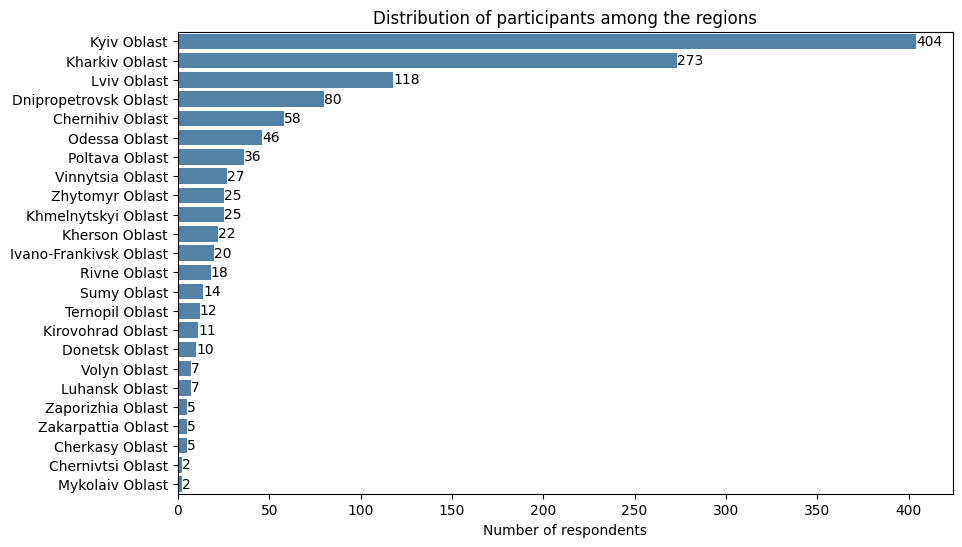

In [673]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_region,
            y='region_en',
            x='number',
            orient = 'h',
            color='steelblue'
            #stat="percent", 
            #discrete=True
            ).set(title='Distribution of participants among the regions',
            xlabel='Number of respondents',
            ylabel=None
            )
#plt.xticks(rotation=70)
ax.bar_label(ax.containers[0])
plt.show()
fig.savefig('../figs/distribution_regions.jpg')

## Quality of sleep

Plot distribution of quality of sleep before the war

   unique_values    counts
0              4  0.449393
1              5  0.321457
2              3  0.176518
3              2  0.029150
4              0  0.016194
5              1  0.007287


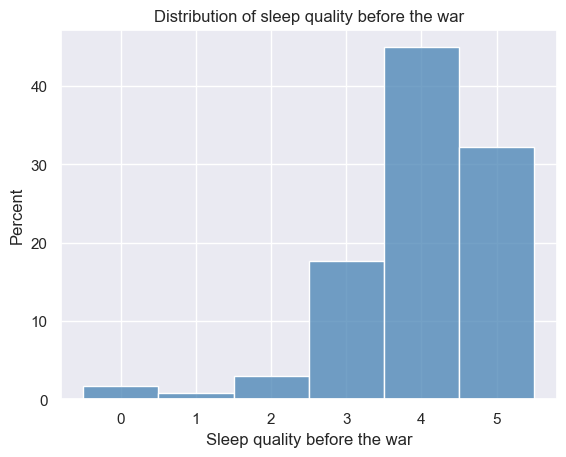

In [781]:
df_qual = df['kidsleep_grade_before'].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
#print('Distribution of sleep quality before the war in %:\n{}'.format(df["8. Як ви б оцінили сон вашої дитини до 24 лютого? (від 1 до 5, де 1 – жахливий сон, 5 – чудовий сон)? "].value_counts(normalize=True)*100))
print(df_qual)
sns.histplot(
        x=df['kidsleep_grade_before'].sort_values(),
        stat="percent",
        color='steelblue',
        discrete=True
        ).set(title='Distribution of sleep quality before the war',
                xlabel='Sleep quality before the war')
plt.show()

## Age of children

### Youngest child

Replace "Дитина народилася після 24 лютого" with 0 and cast column to int

In [587]:
df['kidsleep_grade_before'] = df['kidsleep_grade_before'].replace('Дитина народилася після 24 лютого', 0)
df['kidsleep_grade_before'] = df['kidsleep_grade_before'].astype('int')
df['kidsleep_grade_before'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1235 entries, 0 to 1234
Series name: kidsleep_grade_before
Non-Null Count  Dtype
--------------  -----
1235 non-null   int32
dtypes: int32(1)
memory usage: 4.9 KB


In [682]:
sns.set(font_scale=1)

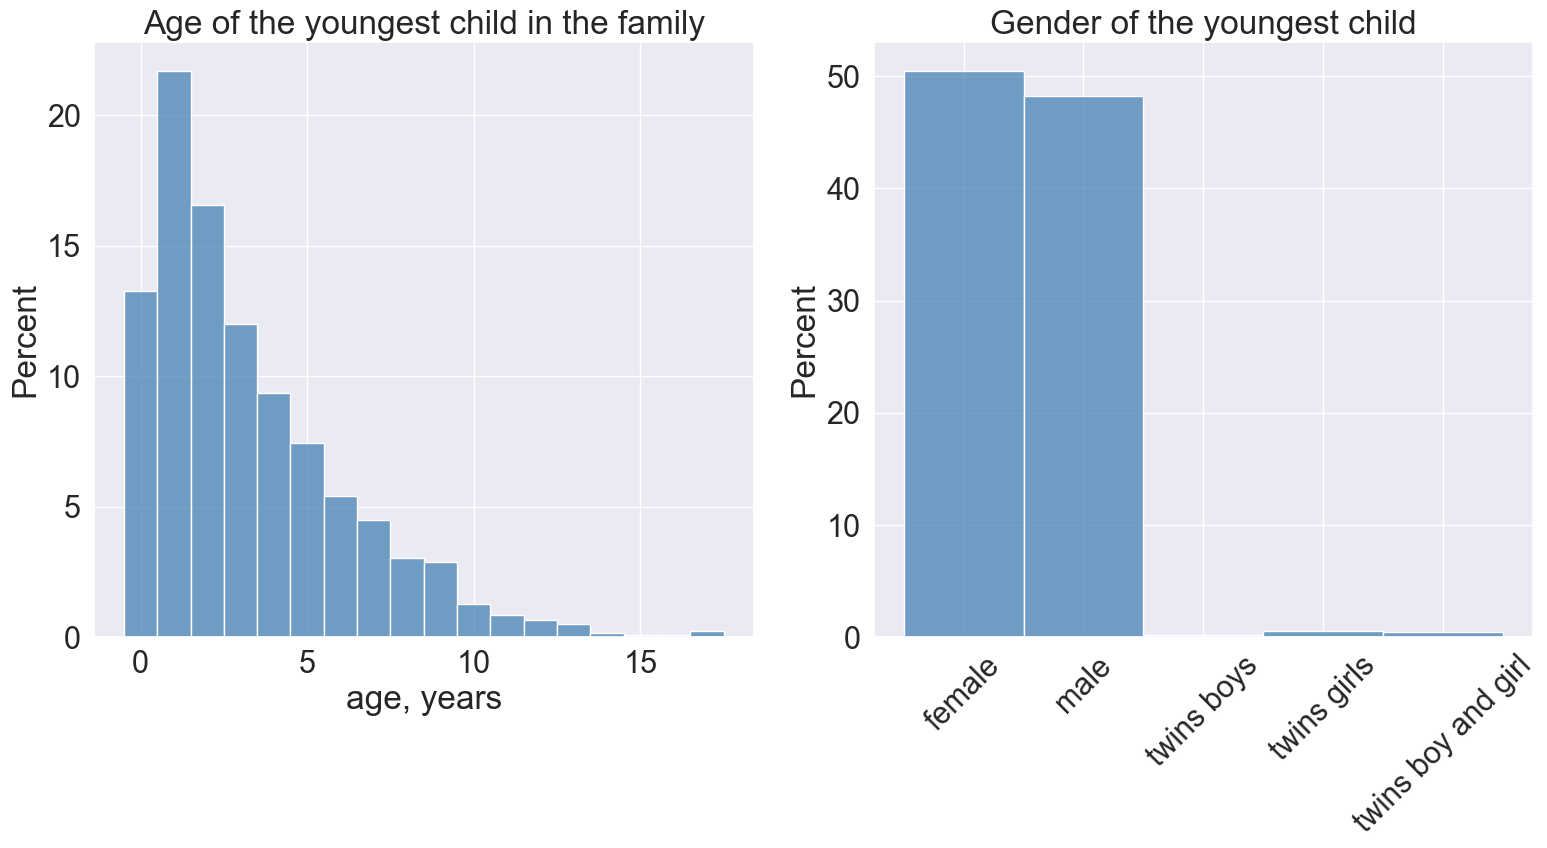

In [678]:
fig, axs = plt.subplots(1, 2, figsize=(16,9), tight_layout=True) #sharey=True to make y axis same
#fig = plt.figure(facecolor=(1, 1, 1))
mask = (df['age_younger']>=0) & (df['age_younger'] <= 18)
#sns.set(font_scale=2)
sns.histplot(ax=axs[0],
                x=df['age_younger'][mask].sort_values(),
                stat="percent",
                color='steelblue',
                discrete=True
                ).set(title='Age of the youngest child in the family',
                        xlabel='age, years')
sns.histplot(ax=axs[1],
        x=df['gender_younger'],
            stat="percent", 
            discrete=True,
            color='steelblue'
            ).set(title='Gender of the youngest child',
            xlabel=None #'gender'
            )
#axs.bar_label(axs.containers[0])
#axs[1].tick_params(rotation=45)
plt.xticks(rotation=45)
fig.savefig('../figs/child_age+gender_2.jpg')
plt.show()

In [48]:
print_all(df.birthday_younger)

0                                           02/08/2016
1                                           07/03/2011
2                                           15/07/2005
3                                           04/11/2016
4                                           23/07/2021
5                                           22/05/2020
6                                           09/03/2021
7                                           02/11/2020
8                                           04/12/2013
9                                           03/06/2021
10                                          20/08/2019
11                                          25/12/2016
12                                          17/10/2017
13                                          29/04/2021
14                                          26/12/2021
15                                          25/09/2020
16                                          11/07/2018
17                                          21/02/2020
18        

In [591]:
# change . and , into "/"

df['birthday_younger'] = df['birthday_younger'].replace(['\.',','],'/', regex=True)

In [592]:
def insert_string_middle(str, word):
    """
    insert the string word in middle of the string, 2 characters before the end
    """
    return str[:-2] + word + str[-2:]

# find rows with a short year (2 digits) and add 20 before the number of the year

df['birthDate_yearShort'] = df['birthday_younger'].apply(lambda x: re.search('\d{1,2}/\d{2}/\d{2}$', x))
df['birthDate_yearShort'] = df['birthDate_yearShort'].apply(lambda x: x.group() if x else x)
#print(df[['birthday_younger','birthDate_yearShort']][df['birthDate_yearShort'].notnull()])

# apply the function for all rows, where the year only has 2 digits

df['birthDate_yearShort'] = df['birthDate_yearShort'][df['birthDate_yearShort'].notnull()].apply(lambda x: insert_string_middle(x, '20'))
#print(df[['birthday_younger','birthDate_yearShort']][df['birthDate_yearShort'].notnull()])
df['birthday_younger'].loc[df['birthDate_yearShort'].notnull()] = df['birthDate_yearShort']


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\1139630106.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birthday_younger'].loc[df['birthDate_yearShort'].notnull()] = df['birthDate_yearShort']


In [593]:
def correct_short_dates_days(column_old, column_new):
    """
    look for dates with one digit day, add a leading zero. 
    only looking for dates with 4 digit year
    fill in the date with leading 0 until it's 10 digits long 
    (should be carried out after all years are 4 digits long)
    """
    df[column_new] = df[column_old].apply(lambda x: re.search('^\d{1,2}/\d{2}/\d{4}', x))
    df[column_new] = df[column_new].apply(lambda x: x.group() if x else x)
    df[column_new] = df[column_new].str.zfill(10)
    return df[column_new]
    #print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])
    #df['birthday_younger'].loc[df.birthDate_short.notnull()] = df['birthDate_short']
    
# look for dates with one digit day, add a leading zero. only looking for dates with 4 digit year

df['birthDate_short'] = df['birthday_younger'].apply(lambda x: re.search('^\d{1,2}/\d{2}/\d{4}', x))
df['birthDate_short'] = df['birthDate_short'].apply(lambda x: x.group() if x else x)

# fill in the date with leading 0 until it's 10 digits long (should be carried out after all years are 4 digits long)

df['birthDate_short'] = df['birthDate_short'].str.zfill(10)
#print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])
df['birthday_younger'].loc[df.birthDate_short.notnull()] = df['birthDate_short']
#print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\1317773207.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birthday_younger'].loc[df.birthDate_short.notnull()] = df['birthDate_short']


In [594]:
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d', '%d.%m.%Y', '%d/%m/%Y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')

def calculate_age(birthdate, countDate=None):
    """
    returns the float with a full number of years between birthdate and countDate. 
    if countDate is not given, takes todays date
    """
    today = date.today()
    if countDate == None:
        countDate = today
    birthdate = to_datetime(birthdate)
    age = countDate.year - birthdate.year - ((countDate.month, countDate.day) < (birthdate.month, birthdate.day))
    return int(age)

df['birthDate'] = df['birthday_younger'].apply(lambda x: re.search('\d{2}/\d{2}/\d{4}', x))
df['birthDate'] = to_datetime(df['birthDate'].apply(lambda x: x.group() if x else x), format='%d/%m/%Y', dayfirst=True, errors='coerce') #format='%d-%m-%Y',

# calculate age with the function age. Age is calculated on the moment of closing the questionnaire (24.09.2022)
closingDate = datetime(2022, 9, 24)
df['age_younger'] = df['birthDate'][df['birthDate'].notnull()].apply(lambda x: calculate_age(x, closingDate))

In [595]:
# print the results of age calculation

print(f'{df.age_younger.isnull().sum()} birth dates could not be processed:')
print_all( df[['birthday_younger', 'birthDate']][df.age_younger.isnull()])
print(f"{len(df[df['age_younger']<0])} have age under 0:")
print_all(df[['birthday_younger', 'birthDate', 'age_younger']][df['age_younger'] < 0])
print(f"{len(df[df['age_younger'] > 18])} have age over 18:")
print_all(df[['birthday_younger', 'birthDate', 'age_younger']][df['age_younger'] > 18])

38 birth dates could not be processed:
                  birthday_younger birthDate
27                               8       NaT
34                             5/8       NaT
45                           1 рік       NaT
59                         5 років       NaT
60                    Серпень 2017       NaT
78                               6       NaT
139                        2 роки        NaT
192                        6 років       NaT
194                         5років       NaT
274                    8/5 місяців       NaT
284                              7       NaT
306                          2/5 р       NaT
309                              9       NaT
354                       6 років        NaT
405                             10       NaT
411                        6 років       NaT
427                              5       NaT
483                     02/92/3015       NaT
552                       1/7 роки       NaT
553                          1 рік       NaT
595             

Age of the older child

- replace unnecessary punctuation and rows with 0
- replace all '-' (one child) with 0 and all other values with 1 and store in multiple_children column

In [776]:
df.age_older = df['birthday_older'].replace(['\.',','],'/', regex=True)
df.age_older = df.birthday_older.replace(['_', '--','"-"', '^0&'], '-', regex=True)
df.age_older[df.age_older.str.contains('"-"')] = '-'
df.age_older[df.age_older.str.contains('«-«')] = '-'
df.age_older[df.age_older.str.contains('“-“')] = '-'
df.age_older[df.age_older.str.contains('«-»')] = '-'
#print_all(df.age_older.value_counts())

df['multiple_children'] = 0
df['multiple_children'][df.age_older == '-'] = 0
df['multiple_children'][df.age_older != '-'] = 1
df['multiple_children'].value_counts()

#df.age_older

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3194926562.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['multiple_children'][df.age_older == '-'] = 0
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3194926562.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['multiple_children'][df.age_older != '-'] = 1


0    804
1    431
Name: multiple_children, dtype: int64

Plot children age distribution based on age_younger column

    unique_values    counts
0             1.0  0.214703
1             2.0  0.163743
2             0.0  0.131161
3             3.0  0.118630
4             4.0  0.092732
5             5.0  0.073517
6             6.0  0.053467
7             7.0  0.044277
8             8.0  0.030075
9             9.0  0.028404
10           10.0  0.012531
11           11.0  0.008354
12           -1.0  0.008354
13           12.0  0.006683
14           13.0  0.005013
15           17.0  0.002506
16           14.0  0.001671
17           15.0  0.000835
18           -8.0  0.000835
19           -5.0  0.000835
20           16.0  0.000835
21           31.0  0.000835


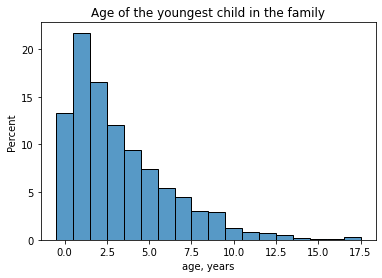

In [597]:
df_age_count = df['age_younger'].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
#print('Distribution of sleep quality before the war in %:\n{}'.format(df["8. Як ви б оцінили сон вашої дитини до 24 лютого? (від 1 до 5, де 1 – жахливий сон, 5 – чудовий сон)? "].value_counts(normalize=True)*100))
print(df_age_count)
img = sns.histplot(
        x=df['age_younger'][(df['age_younger']>=0) & (df['age_younger'] <= 18)].sort_values(),
        stat="percent", 
        discrete=True
        ).set(title='Age of the youngest child in the family',
                xlabel='age, years')
#img.set_xticks(range(18))

plt.show()

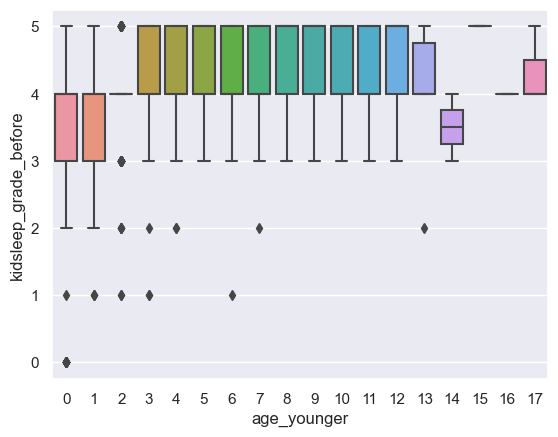

In [705]:
df_age = df[['age_younger', 'kidsleep_grade_before']][df['age_younger']>=0].dropna()
df_age = df_age[df_age['age_younger'] <= 18]
df_age['age_younger'] = df_age['age_younger'].astype('int')

sns.boxplot(data=df_age, x='age_younger', y='kidsleep_grade_before')
plt.show()

In [707]:
df_age = crosstab(index=df_age['age_younger'],
                    columns=df_age['kidsleep_grade_before'],
                    normalize='index')
df_age

kidsleep_grade_before,0,1,2,3,4,5
age_younger,,,,,,
0,0.121019,0.006369,0.031847,0.254777,0.356688,0.229299
1,0.000000,0.011673,0.066148,0.291829,0.447471,0.182879
2,0.000000,0.010204,0.025510,0.193878,0.551020,0.219388
3,0.000000,0.014085,0.007042,0.147887,0.514085,0.316901
4,0.000000,0.000000,0.018018,0.063063,0.504505,0.414414
5,0.000000,0.000000,0.000000,0.090909,0.454545,0.454545
6,0.000000,0.015625,0.000000,0.093750,0.453125,0.437500
7,0.000000,0.000000,0.018868,0.056604,0.433962,0.490566
8,0.000000,0.000000,0.000000,0.083333,0.250000,0.666667


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\666378845.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../figs/age_sleepQuality.jpg', tight_layout=True)


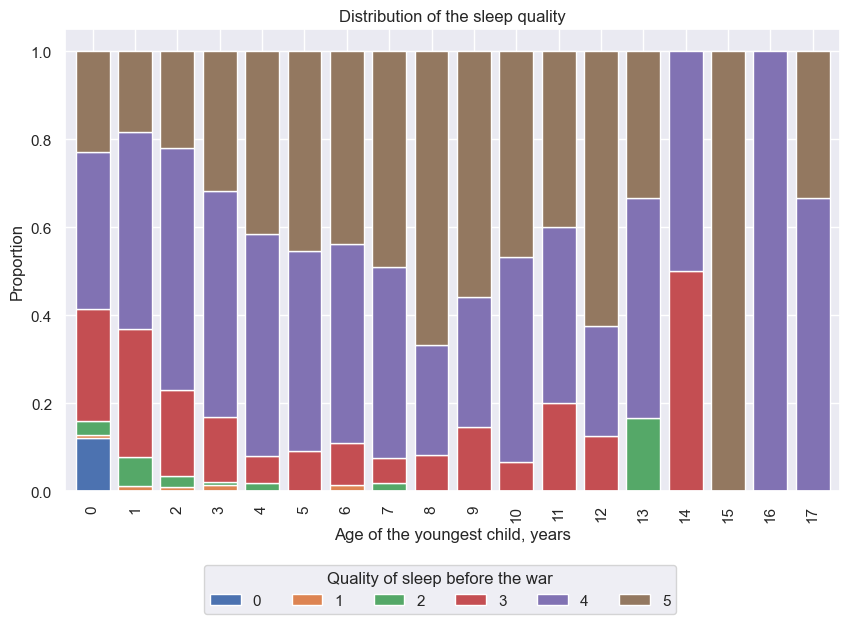

In [758]:
"""
palette = sns.color_palette('YlGnBu')
img = sns.histplot(data=df_age,
                x='age_younger', 
                multiple='fill', 
                hue='kidsleep_grade_before',
                bins=19,
                palette=palette) #.set_xticks(range(18))
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
#img.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
#plt.legend(loc='upper right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
"""
df_age.plot(kind='bar',
            stacked=True,
            width=0.8,
            figsize=(10,6))
#box = ax.get_position()

#ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center', 
            ncol=6, 
            bbox_to_anchor=(0.5, 0), 
            bbox_transform=plt.gcf().transFigure,
            title='Quality of sleep before the war')
#plt.tight_layout()
plt.title('Distribution of the sleep quality')
plt.xlabel("Age of the youngest child, years")
plt.ylabel("Proportion")
plt.savefig('../figs/age_sleepQuality.jpg', tight_layout=True)
plt.show()


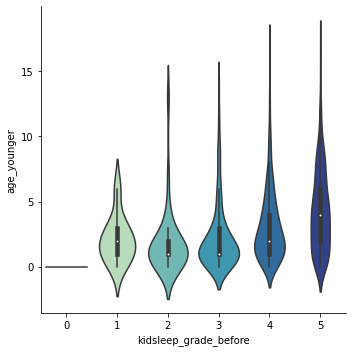

In [94]:
sns.catplot(data=df_age, 
            y='age_younger', 
            x="kidsleep_grade_before", 
            kind='violin'
            )
plt.show()

Subplot with age and gender of the youngest child


In [157]:
fig, axs = plt.subplots(1, 2, figsize=(16,9), tight_layout=True) #sharey=True to make y axis same
#fig = plt.figure(facecolor=(1, 1, 1))
mask = (df['age_younger']>=0) & (df['age_younger'] <= 18)
#sns.set(font_scale=2)
sns.histplot(ax=axs[0],
                x=df['age_younger'][mask].sort_values(),
                stat="percent",
                color='steelblue',
                discrete=True
                ).set(title='Age of the youngest child in the family',
                        xlabel='age, years')
sns.histplot(ax=axs[1],
        x=df['gender_younger'],
            stat="percent", 
            discrete=True,
            color='steelblue'
            ).set(title='Gender of the youngest child',
            xlabel=None #'gender'
            )
#axs.bar_label(axs.containers[0])
#axs[1].tick_params(rotation=45)
plt.xticks(rotation=45)
fig.savefig('../figs/child_age+gender_2.jpg')
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 0 to 1234
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_younger            1184 non-null   float64
 1   kidsleep_grade_before  1184 non-null   int32  
dtypes: float64(1), int32(1)
memory usage: 23.1 KB


## Gender of the youngest child

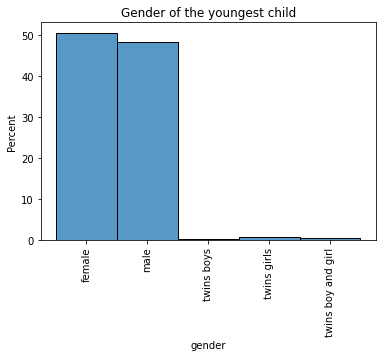

In [598]:
dic_gender = {'Дівчинка': 'female', 
            'Хлопчик':'male', 
            'Двійня - два хлопчики':'twins boys', 
            'Двійня - дві дівчинки': 'twins girls', 
            'Двійня - хлопчик і дівчинка': 'twins boy and girl', 
            'Одна дитина ': np.NAN}
df['gender_younger'] = df['gender_younger'].replace(dic_gender).dropna()
sns.histplot(df['gender_younger'],
            stat="percent", 
            discrete=True
            ).set(title='Gender of the youngest child',
            xlabel='gender'
            )
plt.xticks(rotation=90)
plt.show()

## Health issues

Clean the data:
- replace different versions of "no"
- replace answers with 0, when no health issues known and 1, when there were health issues, save to health_short

In [82]:
# TODO: discuss, if ok for the first analysis to have just yes/no
# TODO: if "no + something" - cut the rest after no

#df['health'].value_counts()
df['health'] = df['health'].str.lower()
df.health = df['health'].str.strip()
dic_healthState = {'-':'ні',
                    '"-"':'ні',
                    'немає':'ні',
                    'не має':'ні',
                    'нема':'ні',
                    'нет':'ні',
                    'не було':'ні',
                    'ні немає':'ні',
                    'ні. все добре':'ні',
                    'не було особливостей':'ні',
                    'ni':'ні',
                    'да': 'так'}
df.health = df.health.replace(dic_healthState)

health_dic = {'ні': 0,
                'так': 1}
df['health_short'] = df['health'].replace(health_dic)
df['health_short'].loc[~df['health_short'].isin([0, 1])] = 1
df['health_short'].value_counts()


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3118174790.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['health_short'].loc[~df['health_short'].isin([0, 1])] = 1


0    918
1    317
Name: health_short, dtype: int64

In [538]:
print('особливості стану здоров’я дитини до 24 лютого:')
print_all(df.health.value_counts())
#df_health = df.health.value_counts()
#df_health = df_health.reset_index()
#df_health.to_csv('../to_discuss/health_conditions')

особливості стану здоров’я дитини до 24 лютого:
Ні                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Left home

In [782]:
print('Залишали місце проживання разом з дітьми\n',
        df['leave_home'].value_counts(normalize=True),
        sep='')

Залишали місце проживання разом з дітьми
Так    0.820243
Ні     0.179757
Name: leave_home, dtype: float64


## Changes in sleep behaviour after begin of the war

### Children

In [783]:
print('Чи змінилась кількість нічних пробуджень дитини\n',
    df['night_wakings_after'].value_counts(normalize=True),
    sep='')

Чи змінилась кількість нічних пробуджень дитини
Так, дещо погіршилася ситуація вночі        0.573279
Ні                                          0.302024
Я не звертала уваги на нічні пробудження    0.086640
Так, дещо покращилася ситуація вночі        0.038057
Name: night_wakings_after, dtype: float64


### Parents

Sleep in February-March

In [466]:
#print_all(df['momsleep_war'].value_counts(normalize=True))
df['momsleep_war_short'] = df['momsleep_war'].str.lower()
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('не спала', case=False)] = 'так'
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('так', case=False)] = 'так'
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('поган', case=False)] = 'так'
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('тривожн', case=False)] = 'так'
df['momsleep_war_short'] = df['momsleep_war_short'].replace(['не змінився','^-'], 'ні', regex=True)
#df['momsleep_war_short'] = df['momsleep_war_short'].replace(['Так','безсоння','тривожно', 'погано'], 'так', regex=True)
print_all(df['momsleep_war_short'].value_counts())

так                                                                                                                                                                                                                                                                                                                                                                                                                                                                            568
ні                                                                                                                                                                                                                                                                                                                                                                                                                                                                              15
безсоння                                                          

In [ ]:
#df['momsleep_war'].loc[df['momsleep_war'] == '-']
print_all(df.loc[df['momsleep_now'].str.contains('так|Покращився|краще', case=False), 'momsleep_now'])
df['momsleep_now_short'].loc[df['momsleep_now'].str.contains('так|Покращився|краще', case=False), 'momsleep_now'] = 'так'

Parents August-September

In [65]:
df['momsleep_now_short'] = df['momsleep_now']
df['momsleep_now_short'] = df['momsleep_now_short'].str.strip().replace('/.', '')
df['momsleep_now_short'] = df['momsleep_now_short'].replace(['Ні', 'ні', 'Майже ні', 'Нет'], 'ні', regex=True)
df['momsleep_now_short'] = df['momsleep_now_short'].replace('Да', 'так', regex=True)
df['momsleep_now_short'].loc[df['momsleep_now_short'].str.contains('так|Покращився|краще', case=False)] = 'так'
print_all(df['momsleep_now_short'].value_counts())

так                                                                                                                                                                                                                                                                                                                                                                                             825
ні                                                                                                                                                                                                                                                                                                                                                                                               73
-                                                                                                                                                                                                                               

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3333467077.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['momsleep_now_short'].loc[df['momsleep_now_short'].str.contains('так|Покращився|краще', case=False)] = 'так'


## Experience of bomb shelter

In [185]:
print('Experience of going to the bomb shelter or cellar with the child')
df['shelter_experience'].value_counts(normalize=True)

Experience of going to the bomb shelter or cellar with the child


Ні                    0.349798
Так, понад 6 разів    0.319028
Так, 1-2 рази         0.204049
Так, 3-5 разів        0.127126
Name: shelter_experience, dtype: float64

In [186]:
print('Experience of the child sleeping in the bomb shelter or cellar')
df['shelter_kidsleep'].value_counts(normalize=True)

Experience of the child sleeping in the bomb shelter or cellar


Так                                                  0.415385
Ні, ми не були і сховищі з дитиною                   0.354656
Ні, ми були там з дитиною тільки під час неспання    0.229960
Name: shelter_kidsleep, dtype: float64

In [36]:
df.sleep_method_change.value_counts(normalize=True)

Ні                                                                                                                                                                                                                                                  0.586235
Так                                                                                                                                                                                                                                                 0.362753
-                                                                                                                                                                                                                                                   0.006478
Після повернення додому - ні. За коридором - так                                                                                                                                                                                                 

In [74]:
df.loc[(df['shelter_experience'] != 'Ні') & (df['shelter_kidsleep'] == 'Ні, ми не були і сховищі з дитиною')]

,time,email,location_before,birthday_younger,gender_younger,age_older,gender_older,feeding,health,kidsleep_grade_before,...,informed_consent,feedback,city_raw,city,birthDate_yearShort,birthDate_short,birthDate,age_younger,momsleep_war_short,momsleep_now_short
129,23.08.2022 22:47:37,oaplume@gmail.com,Дніпро,05/02/2021,Дівчинка,6 років,Дівчина,Грудне вигодовування + прикорм,-,2,...,Так,"Так, відповіді і результати дослідження",дніпро,дніпро,NaN,05/02/2021,2021-02-05,1.0,"сон пропав, інколи просто відключалася від втоми",так
186,24.08.2022 6:53:22,lukianovaolena@gmail.com,Харків,25/05/2020,Хлопчик,-,-,Вже перейшли на дорослу їжу,Ні,4,...,Так,"Так, відповіді і результати дослідження",харків,харків,NaN,25/05/2020,2020-05-25,2.0,так,так
375,25.08.2022 11:47:45,n.samarets1983@gmail.com,Харьков,17/03/2015,Дівчинка,-,-,Вже перейшли на дорослу їжу,Не має,4,...,Так,Ні,харьков,харків,NaN,17/03/2015,2015-03-17,7.0,"не мала змоги спати, пару годин коли дуже втом...",Не можу довго заснути
415,25.08.2022 13:56:17,gory4ka@gmail.com,Київ,09/02/2017,Дівчинка,-,-,Вже перейшли на дорослу їжу,Ні,5,...,Так,"Так, відповіді і результати дослідження",київ,київ,NaN,09/02/2017,2017-02-09,5.0,"донька засинала ,а я чергувала тривоги,поітм в...",так
601,26.08.2022 15:01:13,didukolia2111@gmail.com,Львів,31/08/2015,Дівчинка,-,-,Вже перейшли на дорослу їжу,Ні,3,...,Так,"Так, тільки результати дослідження",львів,львів,NaN,31/08/2015,2015-08-31,7.0,погано сплю,так
819,31.08.2022 9:20:47,rybalka.2344@gmail.com,Запоріжжя,01/09/2012,Дівчинка,-,-,Грудне вигодовування,Ні,5,...,Так,"Так, відповіді і результати дослідження",запоріжжя,запоріжжя,NaN,01/09/2012,2012-09-01,10.0,"так, прокидаюсь від маленького шуму",ні
867,06.09.2022 14:11:45,anna.gribinukova@gmail.com,Киів,2/5 на момент 24 лютого 2022,Хлопчик,-,-,Вже перейшли на дорослу їжу,Зуби та зір,5,...,Так,"Так, відповіді і результати дослідження",киів,київ,NaN,None,NaT,NaN,я дуже важко спала. дитина трошки гірше ніж за...,так
1083,07.09.2022 21:39:54,sashazvzvzv@gmail.com,Дніпро,02/05/2021,Дівчинка,-,-,Вже перейшли на дорослу їжу,Ні,2,...,Так,"Так, відповіді і результати дослідження",дніпро,дніпро,NaN,02/05/2021,2021-05-02,1.0,"сон став дуже чуттєвий.я часто прокидалась ,що...",так


## General information about parents

### Age

In [509]:
df.age = df.age.astype('int')
#df.age.value_counts()
#sns.displot(df.age)

['04.04.1990', '01.12.1992', '22.08.1997', '26.02.1978', '01.01.1985', '16.07.1995'] 2022-09-24 00:00:00


c:\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


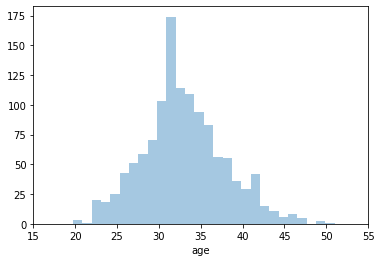

In [513]:
# age distribution
df.age = df.age.replace(' роки', '', regex = True)
df.age.loc[df.age == '26 років, (14.08.1996) '] = 26
df.age = df.age.replace('Недавно стукноло 38', '38')

# replace values for rows with dates of birth using user function calculate_age
age_to_calculate = ['04.04.1990',
                    '01.12.1992',
                    '22.08.1997',
                    '26.02.1978',
                    '01.01.1985',
                    '16.07.1995']
#print(age_to_calculate, closingDate)
age_calculated = {}
for a in age_to_calculate:
    age_calculated[a] = calculate_age(to_datetime(a, format='%d.%m.%Y'), closingDate)

df.age = df.age.replace(age_calculated)
df.age.value_counts()

i = df[df.age == 'Спокію'].index
df = df.drop(i)

sns.distplot(df.age, kde=False)
plt.xlim(15, 55)
plt.show()


### Education

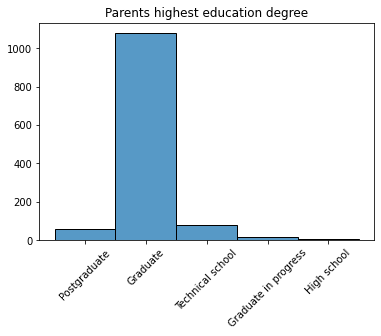

In [521]:
edu = {'Шкільна':'High school',
    'Середня спеціальна': 'Technical school',
    'Вища (в процесі навчання)':'Graduate in progress',
    'Вища (балалавр, магістр)': 'Graduate',
    'Науковий ступінь (кандидат, доктор наук)':'Postgraduate'
    }

df.education_en = df.education.replace(edu)
df.education_en.value_counts()
sns.histplot(df.education_en,
            discrete=True
            ).set(title='Parents highest education degree',
            xlabel=None,
            ylabel=None
            )
plt.xticks(rotation=45)
plt.show()

In [542]:
df_relationship = read_csv('../data/relationship_outliers.csv')
dic_relationship = df_relationship.dropna().set_index('index')['change'].to_dict()
dic_relationship

{'Все складно': 'Невизначений',
 'У розлуці уже півроку': 'У шлюбі',
 'Заміжня, але зараз живу з дитиною в моїх батьків, чоловік повернувся в Ірпінь. Приізжає до нас на 2 дні в місяць ': 'У шлюбі',
 'Чоловік нас покинув, але підтримуємо поважні стосунки, з дитиною не бачився і особливо не спішить, дізнається як справи, але по віде або телефону спілкувався 5 разів за півроку': 'Невизначений',
 'Проживаю з батьками та дитиною за кордоном': 'У шлюбі',
 'Чекаю на чоловіка, намагаємося зустрітися': 'У шлюбі',
 'після окупації прийняли рішення одружитись, 20.08 одружилися після 13 років спільного життя': 'У шлюбі',
 'Але чоловік єра з нами немає': 'У шлюбі',
 'Невизначений': 'Невизначений',
 'Чоловік військовослужбовець, на фронті': 'У шлюбі',
 'Одинока мама': 'Проживаю сам (-а) з дитиною',
 'Все спільне тільки немає штампа в паспорті': 'У стосунках з партнером',
 'Переживаємо кризу відносин .': 'Невизначений',
 'Але чоловік на фронті': 'У шлюбі'}

In [788]:
df.relationship_short = df.relationship

df.relationship_short.loc[df.relationship.str.contains('У шлюбі', case=False)] = 'У шлюбі'
df.relationship_short.loc[df.relationship.str.contains('вдова', case=False)] = 'Вдова'
df.relationship_short.loc[df.relationship.str.contains('розлучен', case=False)] = 'Розлучені'
df.relationship_short.loc[df.relationship.str.contains('Замужем', case=False)] = 'У шлюбі'
df.relationship_short = df.relationship_short.replace(dic_relationship)


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\901662329.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.relationship_short = df.relationship
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\901662329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relationship_short.loc[df.relationship.str.contains('У шлюбі', case=False)] = 'У шлюбі'
C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\901662329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relationship_short.loc[df

In [792]:
df.relationship_short.loc[df.relationship_short == ''] = 'Невизначений'
#df_relationship = df_regions.set_index('village')['region'].to_dict()
df.relationship_short.value_counts()

У шлюбі                        1120
Проживаю сам (-а) з дитиною      42
У стосунках з партнером          34
Розлучені                        28
Невизначений                      7
Вдова                             4
Name: relationship, dtype: int64

In [537]:
df_relationship = df.relationship_short.value_counts()
df_relationship = df_relationship.reset_index()